# Monte Carlo Simulation

In this demonstration, I will be show my understanding of the concepts of Monte carlo Simulation. I will be using historical observations to estimate the probability distributions of data. I will simulate multiple outcomes of uncertain variables and summarize the distrubution using confidence intervals.

I will be pulling MSFT data from Yahoo Finance from start of 2000 to end of 2022 and predicting stock prices for the next 250 days, value at risk (VaR) calculation. In addition, I will also use monte carlo simulation to predict net income forecast and capital investment NPV forecast of sample companies.

In [1]:
# Install yfinance (Yahoo Finance market data downloader) 
!pip install yfinance

In [2]:
# Import external packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

## 1. Stock Price Prediction Model

### Steps 
1. Place the daily historical stock prices into a Pandas dataframe
2. Create a dataframe of daily log returns
3. Plot a distribution of returns to confirm assumptions
4. Calculate historical statistical measures of the daily log returns 
5. Simulate price over the next 250 days (random log returns)
6. Convert log returns back into simple returns
7. Calculate the price progression for each of our simulations

### Observations - Extract Data from Yahoo Finance


[*********************100%***********************]  1 of 1 completed


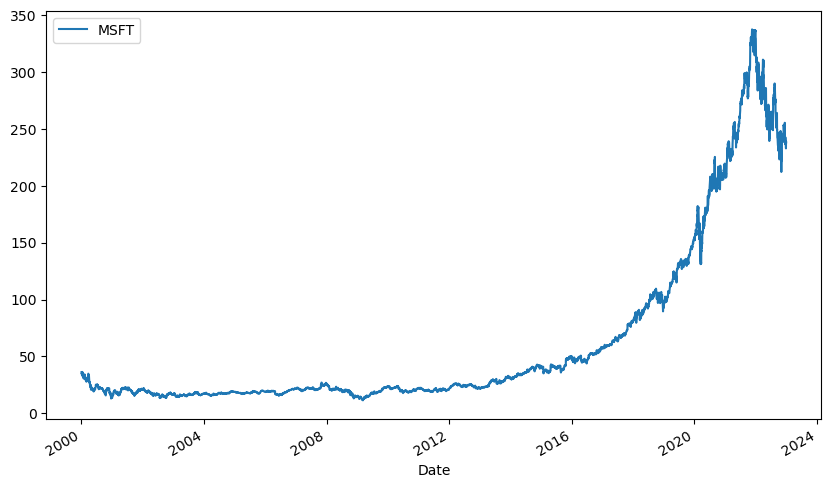

In [4]:
# Extract data from Yahoo Finance
ticker = 'MSFT' 
stock_data = pd.DataFrame()
stock_data[ticker] = yf.download(ticker, start='2000-1-1',end='2022-12-31')['Adj Close']

# Plot MSFT closing prices
stock_data.plot(figsize=(10, 6));

### Distributions - Calculate Historical Returns and Statistical Measures

### Log returns 

A dataframe of daily log returns will be calculated. I am using log retuens because it is time additive, symmetric and they are more closely represented by a normal distribution. They will then be converted back into simple returns by using the exponential function

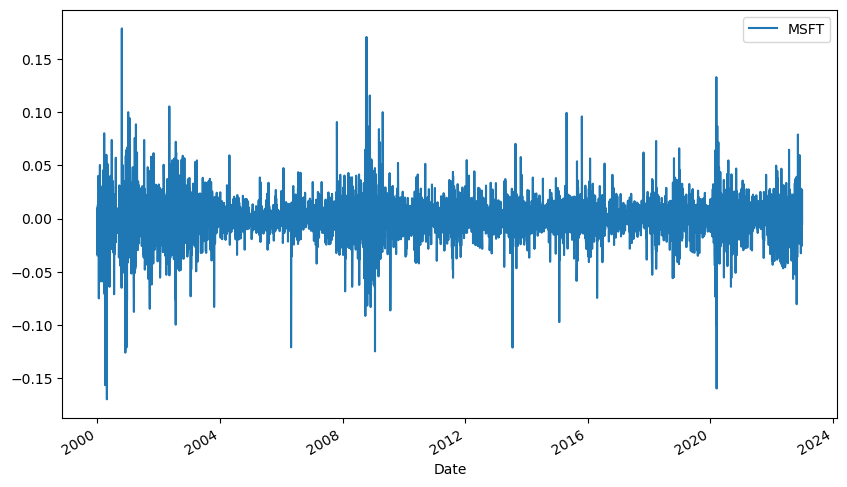

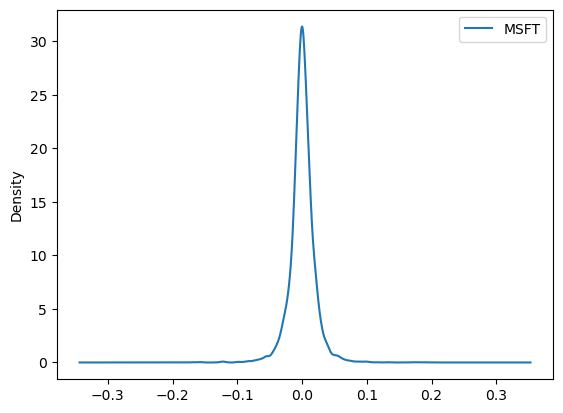

In [6]:
# Calculate historical log returns
log_returns = np.log(1 + stock_data.pct_change())

# Show all the log returns
log_returns.plot(figsize = (10, 6));

# Show the distribution of the log returns
log_returns.plot.density();

In [8]:
# Calculate key statistic measures
mean = log_returns.mean()
variance = log_returns.var()
STD = log_returns.std()

### Simulations - Simulate Future Daily Returns and Future Prices

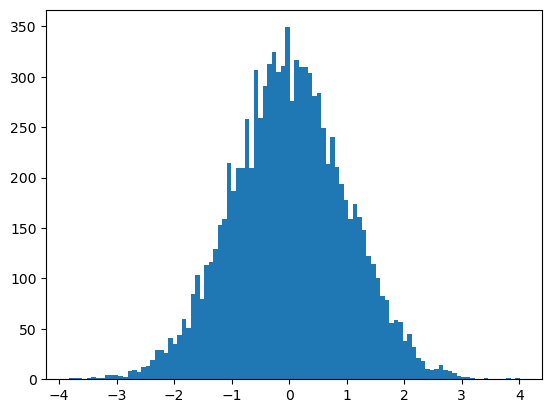

In [10]:
# How to generate 10,000 random numbers betwen 0 and 1.
random_numbers = np.random.rand(10000)

# Use those randomly generated numbers to sample from a normal distribution
normal_random_numbers = norm.ppf(random_numbers)

# Plot each of the 10,000 randombly generated numbers from the normal distribution
plt.hist(normal_random_numbers, bins = 100);

In [11]:
# Simulate future daily returns using the above method
t_intervals = 250 
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_simplereturns_simulated = np.exp(daily_logreturns_simulated)
daily_simplereturns_simulated.shape

(250, 10000)

In [12]:
# Using returns, calculate future price progression in each simulation

# Latest known stock price for MSFT
last_price = stock_data.iloc[-1]

# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated)

# Set the first row to the starting stock price
price_list[0] = last_price

price_list

array([[238.19471741, 238.19471741, 238.19471741, ..., 238.19471741,
        238.19471741, 238.19471741],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

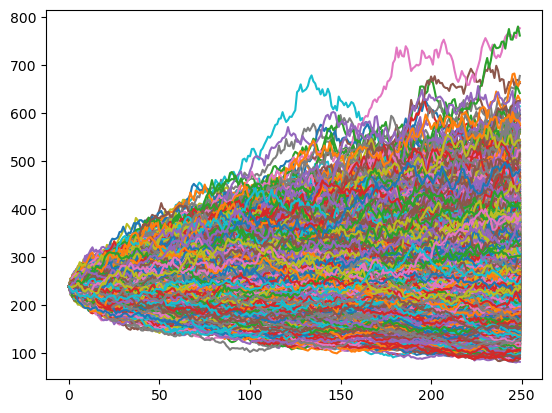

In [13]:
 #Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_simulated[t]

# Plot simulated future MSFT prices
plt.plot(price_list);

### Including Drift

In [15]:
# Calculate drift
drift = mean - (0.5*variance)

# Simulate future daily returns
t_intervals = 250
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_logreturns_simulated_withdrift = daily_logreturns_simulated +drift.values
daily_simplereturns_simulated_withdrift = np.exp(daily_logreturns_simulated_withdrift)

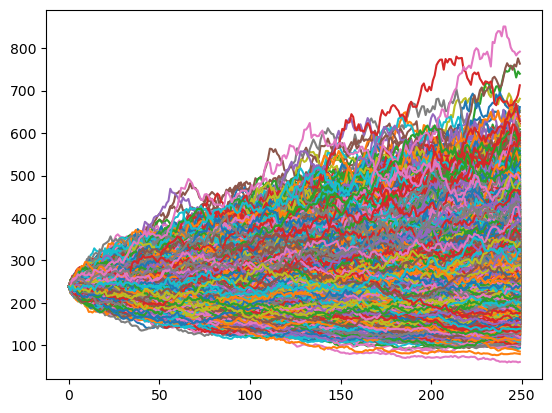

In [16]:
# Create a variable for the latest price of MSFT
last_price = stock_data.iloc[-1]

# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated_withdrift)

# Set the first row to the starting stock price
price_list[0] = last_price

# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_simulated_withdrift[t]

# Plot simulated future MSFT prices
plt.plot(price_list);

### Quantifications - Examine the worst, average, best scenarios and the probability distribution

In [19]:
# Calculate worst, avg and best scenarios
WorstSim = round(price_list[-1].min(),2)
AvgSim = round(price_list[-1].mean(),2)
BestSim = round(price_list[-1].max(),2)

# Examine the worst, average, and best stock price sceanrios
print("Best and Worst Cases")
print(f"Worst Simulation $/share: {WorstSim}")
print(f"Avg Simulation $/share: {AvgSim}")
print(f"Best Simulation $/share: {BestSim}")

# Set up confidence intervals
Mean_Day250Prices = price_list[-1].mean()
SD_Day250Prices = price_list[-1].std()
UpperInterval_1SD = Mean_Day250Prices + 1 * SD_Day250Prices 
LowerInterval_1SD = Mean_Day250Prices - 1 * SD_Day250Prices
UpperInterval_2SD = Mean_Day250Prices + 2 * SD_Day250Prices
LowerInterval_2SD = Mean_Day250Prices - 2 * SD_Day250Prices

# Print out the price range within the confidence intervals
print("\n" + "Confidence Intervals")
print(f"1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: ${LowerInterval_1SD} and ${round(UpperInterval_1SD,2)}")
print(f"2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: ${round(LowerInterval_2SD,2)} and ${round(UpperInterval_2SD,2)}")

Best and Worst Cases
Worst Simulation $/share: 60.67
Avg Simulation $/share: 259.63
Best Simulation $/share: 791.91

Confidence Intervals
1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: $177.55262208871784 and $341.7
2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: $95.48 and $423.78


## 2. Value at Risk Assessment

Here, I will be assessing the risk of purchasing 1000 MSFT shares and holding them for one month with key information like current value and 30 day historic volatility

In [20]:
# Number of shares
shares_MSFT = 1000

# Live stock price
price = yf.Ticker('MSFT')
price_MSFT = price.history().tail(1)['Close'].iloc[0]

print(price)
print('---------')
print(price_MSFT)

yfinance.Ticker object <MSFT>
---------
319.9700012207031


In [54]:
# Investment value
value_MSFT = price_MSFT * shares_MSFT

# Risk free rate (4 week treasury bill rate)
rfr_MSFT = 0.05 

# Volatility (30-day volatility at that time)
vol_MSFT = 0.2328

### Simulations - Calculate Investment Returns

In [55]:
# Number of simulations
simulations = 5000 

# Investment time in a year
t_MSFT = 21/252 

(array([  3.,   2.,   1.,   5.,   0.,   3.,   4.,   5.,   7.,   2.,  13.,
          6.,   9.,  11.,  12.,  18.,  18.,  17.,  20.,  20.,  28.,  34.,
         30.,  45.,  45.,  48.,  57.,  58.,  65.,  69.,  70.,  85.,  97.,
        107.,  93., 112., 106., 116., 151., 141., 126., 129., 135., 129.,
        153., 137., 159., 134., 138., 127., 116., 144., 131., 101., 110.,
        117.,  97., 110.,  81.,  99.,  72.,  83.,  78.,  66.,  61.,  52.,
         43.,  46.,  39.,  33.,  35.,  23.,  22.,  17.,  21.,  20.,  10.,
         17.,  16.,   5.,  10.,   5.,   2.,   3.,   6.,   3.,   3.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.24693206, -3.17564027, -3.10434848, -3.03305669, -2.9617649 ,
        -2.89047311, -2.81918132, -2.74788952, -2.67659773, -2.60530594,
        -2.53401415, -2.46272236, -2.39143057, -2.32013878, -2.24884699,
        -2.1775552 , -2.1062634 , -2.03497161, -1.96367982, -1.89238803,
        -1.82109624, -1.74

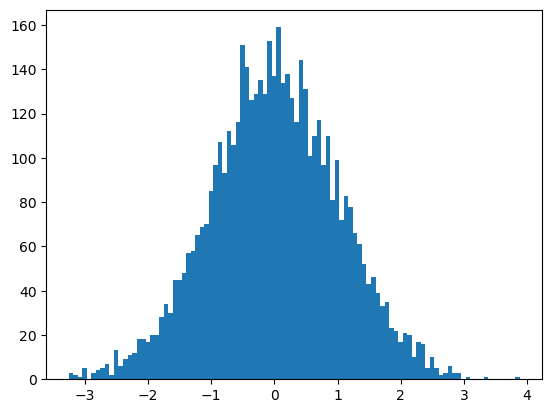

In [56]:
# Explain np.random.standard_normal
sample = np.random.standard_normal(5000)
plt.hist(sample,bins=100)

In [57]:
print(np.mean(sample))
print(np.std(sample))

0.014134030430502785
1.0112414529777303


In [58]:
# Create a function to calculate the returns of the investment
def VaR(pv, rfr, vol, t, simulations):
    end_value = pv * np.exp((rfr - .5 * vol ** 2) * t + np.random.standard_normal(
        simulations) * vol * np.sqrt(t))
    returns = end_value - pv
    return returns

# Apply the VaR function to simulate the returns
returns_MSFT = VaR(value_MSFT, rfr_MSFT, vol_MSFT, t_MSFT, simulations)

### Quantifications - Identify VaR at 90%, 95%, and 99% Confidence Level

VaR at 90% confidence level: $-24,981
VaR at 95% confidence level: $-32,147
VaR at 99% confidence level: $-45,994


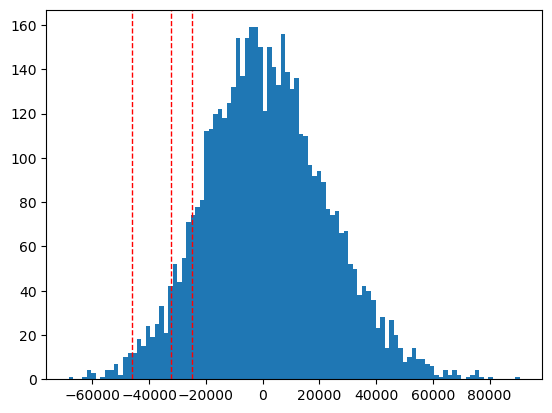

In [59]:
# Plot the returns
plt.hist(returns_MSFT, bins=100);

# Show VaR at 90%, 95%, and 99% confidence level
percentiles = [10,5,1]

for i in percentiles:
    confidence = (100-i)/100
    value = np.percentile(returns_MSFT, i)
    print("VaR at {:.0%} confidence level: ${:,.0f}".format(confidence, value))
    plt.axvline(value, color = 'red', linestyle='dashed', linewidth=1)

## 3. Net Income Forecast

### Distributions - Assumptions

In [37]:
# Create variables for assumptions 
sales_mean = 50
sales_std = 5
COGS_mean = 0.15
COGS_std = 0.1

### Simulations - Simulate Sales, COGS, and Net Income

In [39]:
# Generate sales samples 
simulations = 10000
sales_sims = np.random.normal(sales_mean, sales_std, simulations)

print(sales_sims)
print("mean:", np.mean(sales_sims))
print("std:", np.std(sales_sims))

[40.40127323 45.50739289 48.54350553 ... 59.19668973 51.39690001
 53.81220037]
mean: 50.076401847617106
std: 4.989322366689781


In [40]:
# Generate COGS samples
COGS_sims = - (sales_sims * np.random.normal(COGS_mean,COGS_std))

# Generate net income simulations
profit_sims = sales_sims + COGS_sims

### Quantifications - Examine the Worst, Average, Best scenarios and the Probability Distribution

In [42]:
# Examine the worst, average, and best cases
print("Worst case:", min(profit_sims))
print("Average case:", profit_sims.mean())
print("Best case:", max(profit_sims))

Worst case: 29.96391594879039
Average case: 47.019473090648
Best case: 66.21072456269108


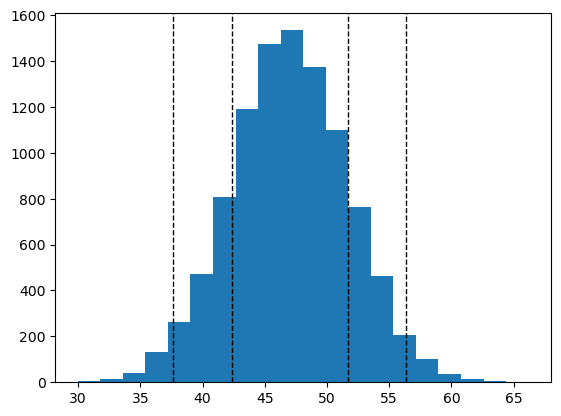

68% profit range: $42.33 and $51.7
95% profit range: $37.65 and $56.39


In [43]:
# Set up confidence intervals
upper68 = profit_sims.mean()+profit_sims.std()
lower68 = profit_sims.mean()-profit_sims.std()
upper95 = profit_sims.mean()+profit_sims.std()*2
lower95 = profit_sims.mean()-profit_sims.std()*2

# Plot the probability distribution
plt.hist(profit_sims, bins = 20);
plt.axvline(upper68, color = 'k', linestyle='dashed', linewidth=1)
plt.axvline(lower68, color = 'k', linestyle='dashed', linewidth=1)
plt.axvline(upper95, color = 'k', linestyle='dashed', linewidth=1)
plt.axvline(lower95, color = 'k', linestyle='dashed', linewidth=1)
plt.show()

# Print out confidence intervals
print(f"68% profit range: ${round(lower68,2)} and ${round(upper68,2)}")
print(f"95% profit range: ${round(lower95,2)} and ${round(upper95,2)}")

## 4. Capital Investment NPV Forecast

In [45]:
!pip install numpy-financial

In [46]:
import numpy_financial as npf

### Set Up the Financial Assumptions

In [48]:
# Initial investment cost of the equipment and production estimates
costEquipment = 750000

# Number of years to generate revenue
numberOfYears = 5 

# Total number of years in the model
totalYear = numberOfYears+1

# Business assumptions
COGSpercent = 0.375
salariesBenefits = 160427
salariesBenefits0 = 82750
otherCost = 10963
workingCapital = 9003 
tax = 0.25

# Production assumptions
price_mean = 25
price_std = 0.5

units_mean = 35000
units_std = 2000

# Discount rate 
discRate_mean = 0.15
discRate_std = 0.02

### Simulate Variables 

[24.4571847  25.49867272 25.14148925 ... 24.76386679 25.29098218
 25.48530643]
[32518.06065558 34374.10642993 33302.1064165  ... 32194.32036611
 37089.08172498 35738.56223552]
[0.17063187 0.1766389  0.15191688 ... 0.12710549 0.14052637 0.18319834]


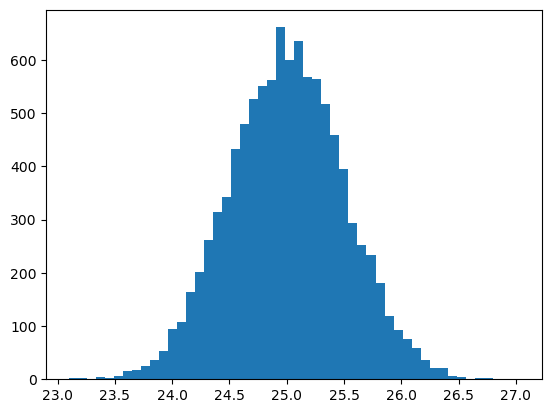

In [50]:
# Set up random seed for reproducibility
np.random.seed(123) 

# Number of simulations
simulations = 10000

# Simulate the price, units, and discount rate
price_sim = np.random.normal(price_mean, price_std, simulations)
units_sim = np.random.normal(units_mean, units_std, simulations)
discRate_sim = np.random.normal(discRate_mean, discRate_std, simulations)

# Examine the simulations
print(price_sim)
print(units_sim)
print(discRate_sim)

plt.hist(price_sim, 50)
plt.show()

### Simulate the Free Cash Flow (FCF) and Net Present Value (NPV)

In [51]:
# Create a list of ones
all_years_constant = np.ones(totalYear)
all_years_constant

array([1., 1., 1., 1., 1., 1.])

In [52]:
# Create a list to contain all NPV simulations
npv=[]

# Create a for loop to go through 10,000 simulations
for i in np.arange(simulations):
        
    # Sales from year 0 to year 5 
    units=all_years_constant*units_sim[i]
    sales=units*price_sim[i]
    sales[0]=0  
    
    # COGS from year 0 to year 5
    COGS=sales*COGSpercent
    
    # Salaries from year 0 to year 5
    salaries=all_years_constant*salariesBenefits
    salaries[0]=salariesBenefits0
    
    # Other expenses from year 0 to year 5
    other=all_years_constant*otherCost
    other[0]=0
    
    # Depreciation from year 0 to year 5
    depreciation=all_years_constant*costEquipment/numberOfYears   
    depreciation[0]=0                            
    
    # Net increase in working capital from year 0 to year 5
    WC=all_years_constant*workingCapital
    WC[0]=0
    
    # Equipment cost from year 0 to year 5
    equipment=np.zeros(totalYear) 
    equipment[0]=costEquipment 
    
    # Calculate EBIT
    EBIT=sales-COGS-salaries-other-depreciation 
    
    # Calculate NOPAT(net operating profit after taxes)
    NOPAT=EBIT*(1-tax)                   
    
    # Calculate FCF (free cash flow)
    FCF=NOPAT+depreciation-WC-equipment
    
    # Calculate NPV
    R=discRate_sim[i]
    npvProject=npf.npv(R,FCF)/1000
    
    # Add npvProject to the list of all NPV simulations
    npv.append(npvProject)

### Analyze the Profitability of the Investment

min  NPV = -90
mean NPV = 231
max  NPV = 654


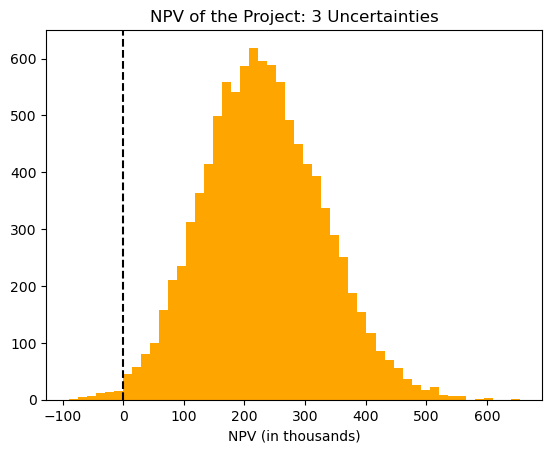

In [53]:
# pint the minimum, average and maximum NPV
print("min  NPV =",round(min(npv)))
print("mean NPV =",round(np.mean(npv)))
print("max  NPV =",round(max(npv)))

# Plot the data distribution
plt.hist(npv, 50, color='orange')
plt.title("NPV of the Project: 3 Uncertainties")
plt.xlabel("NPV (in thousands)")
plt.axvline(0, color = 'k', linestyle='dashed')
plt.show()